# Comparaison de performences de l'image captioning de llava sur plusieurs prompts

On compare diférents prompts selon les métriques CIDER, BLEU, SPICE, CHAIR et METEOR sur des images de COCO val2017.

Le modèle testé par défaut est llava.

### Les resultats ainsi qu'une courte analyse de la simulation sont disponible à la fin de notebook

------------------------------------------------------------------------------------------------------------------------------------------------------------

In [1]:
from PIL import Image
import pickle
import os
from pathlib import Path
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from evaluation.Scorer import Scorer
from core.Model import Model


load_dotenv()

C:\Users\bogae\Documents\java8\jdk8u472-b08\bin\java.exe


True

In [2]:
PROMPTS = [
    "Describe this image. Be concise.",
    "Provide a very short, concise, and factual caption for this image. Maximum 10 words.",
    "Décris cette image. Sois factuel et concis. Pas plus de dix mots."
]
# Il est nécessaire de demander des réponses concises à cause de la conssommation en RAM de Spice qui peut planter.

# Images
dataset_root = Path(os.getenv("DATASET_PATH", "."))
IMG_FOLDER = dataset_root / "val2017"
NUM_IMG = 20
print(IMG_FOLDER)
IMGS_PATH = list(IMG_FOLDER.rglob('*.jpg'))[:NUM_IMG]
print(IMGS_PATH)
# Test images
IMG_TEST_PATH = IMGS_PATH[0]
IMG_TEST_ID = int(Path(IMG_TEST_PATH).stem)

# CHAIR
PATH_INSTANCES = dataset_root / "annotations/instances_val2017.json"
PATH_SYNONYMS = "data/our_data/coco_synonyms_SOTA.txt"

models_list = os.getenv("AVAILABLE_MODELS", "").split(",")
print(models_list)

base_model = os.getenv("DEFAULT_MODEL","")

C:\Users\bogae\Desktop\NLP\data\coco\val2017
[WindowsPath('C:/Users/bogae/Desktop/NLP/data/coco/val2017/000000000139.jpg'), WindowsPath('C:/Users/bogae/Desktop/NLP/data/coco/val2017/000000000285.jpg'), WindowsPath('C:/Users/bogae/Desktop/NLP/data/coco/val2017/000000000632.jpg'), WindowsPath('C:/Users/bogae/Desktop/NLP/data/coco/val2017/000000000724.jpg'), WindowsPath('C:/Users/bogae/Desktop/NLP/data/coco/val2017/000000000776.jpg'), WindowsPath('C:/Users/bogae/Desktop/NLP/data/coco/val2017/000000000785.jpg'), WindowsPath('C:/Users/bogae/Desktop/NLP/data/coco/val2017/000000000802.jpg'), WindowsPath('C:/Users/bogae/Desktop/NLP/data/coco/val2017/000000000872.jpg'), WindowsPath('C:/Users/bogae/Desktop/NLP/data/coco/val2017/000000000885.jpg'), WindowsPath('C:/Users/bogae/Desktop/NLP/data/coco/val2017/000000001000.jpg'), WindowsPath('C:/Users/bogae/Desktop/NLP/data/coco/val2017/000000001268.jpg'), WindowsPath('C:/Users/bogae/Desktop/NLP/data/coco/val2017/000000001296.jpg'), WindowsPath('C:/Us

## UTILS

Load captions for each picture.

In [3]:
CAPTIONS_MAP_PATH = Path("data/our_data/captions_map.pkl")

if not os.path.exists(CAPTIONS_MAP_PATH):
    print("Fichier introuvable.")
else:
    with open(CAPTIONS_MAP_PATH, "rb") as f:
        coco_captions = pickle.load(f)
        print(f"ground truth captions loaded : {len(coco_captions)}")

ground truth captions loaded : 5000


# Model

In [4]:
model = Model(model_name=base_model,prompts=PROMPTS,imgs_path=IMGS_PATH,coco_captions=coco_captions)
print(f"base model : {base_model}")

base model : llava


# Demo image test

--- Starting analysis. Selected images : 1 ---
Analyse 1/1 : 139, C:\Users\bogae\Desktop\NLP\data\coco\val2017\000000000139.jpg
    The image shows an interior view of a modern, spacious living room. The room has wooden flooring and is furnished with various pieces of furniture including a dining table, chairs, a sofa, and a TV stand. There's a large window allowing natural light in. The walls are painted in different colors, creating a vibrant atmosphere. A kitchen area is visible at the back of the living room, featuring an oven and a sink.
Model captions : 
The image shows an interior view of a modern, spacious living room. The room has wooden flooring and is furnished with various pieces of furniture including a dining table, chairs, a sofa, and a TV stand. There's a large window allowing natural light in. The walls are painted in different colors, creating a vibrant atmosphere. A kitchen area is visible at the back of the living room, featuring an oven and a sink.


Ground truth c

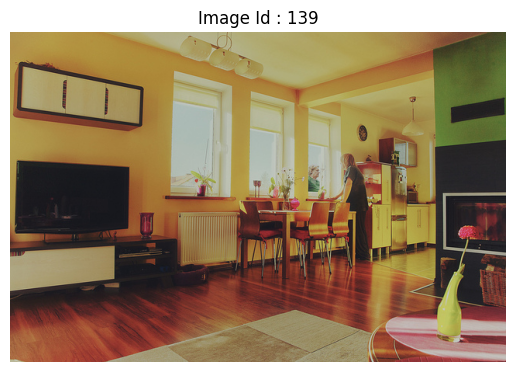

In [5]:
test_model = Model(model_name=base_model,prompts=PROMPTS,imgs_path=[IMG_TEST_PATH],coco_captions=coco_captions)
test_model_responses,test_gt_captions_dict = test_model.execute(prompt_id=0,freq_print=1)
available_keys = list(test_model_responses.keys())
test_responses = {}
test_responses[IMG_TEST_ID] = []
for val in test_model_responses[IMG_TEST_ID]:
   test_responses[IMG_TEST_ID].append(val)

print(f"Model captions : ")
for str in test_responses[IMG_TEST_ID]:
   print(f"{str}")
print("\n")

print(f"Ground truth captions : ")
for str in test_gt_captions_dict[IMG_TEST_ID]:
   print(f"{str}")

img = Image.open(IMG_TEST_PATH)
plt.imshow(img)
plt.axis('off') # Pour cacher les axes X et Y
plt.title(f"Image Id : {IMG_TEST_ID}")
plt.show()

# METRIQUES sur l'image de test

In [6]:
print(test_gt_captions_dict)
print(test_model_responses)

scorer = Scorer(path_instances=PATH_INSTANCES,path_synonyms=PATH_SYNONYMS)

results = scorer.compute_scores(test_gt_captions_dict, test_model_responses)

print("\n--- Résultats Finaux ---")
for metric, score in results.items():
   print(f"{metric}: {score:.4f}")

{139: ['A woman stands in the dining area at the table.', 'A room with chairs, a table, and a woman in it.', 'A woman standing in a kitchen by a window', 'A person standing at a table in a room.', 'A living area with a television and a table']}
{139: ["The image shows an interior view of a modern, spacious living room. The room has wooden flooring and is furnished with various pieces of furniture including a dining table, chairs, a sofa, and a TV stand. There's a large window allowing natural light in. The walls are painted in different colors, creating a vibrant atmosphere. A kitchen area is visible at the back of the living room, featuring an oven and a sink."]}
Calcul de CIDEr...
Calcul de Bleu...
{'testlen': 73, 'reflen': 11, 'guess': [73, 72, 71, 70], 'correct': [17, 5, 0, 0]}
ratio: 6.636363635760331
Calcul de METEOR...
Calcul de SPICE...
Calcul de CHAIR...

--- Résultats Finaux ---
CIDEr: 0.0000
Bleu_1: 0.2329
Bleu_2: 0.1272
Bleu_3: 0.0000
Bleu_4: 0.0000
METEOR: 0.1824
SPICE: 0.

---------------------------------------------------------------------------------------------------------------------------------------------------------------

# Comparer prompts

In [7]:
prompts_scores = {}
for i,prompt in enumerate(PROMPTS):
    prompts_scores[i] = {}
    prompts_scores[i]["prompt"]=prompt

    model_responses,gt_captions_dict = model.execute(prompt_id=i,freq_print=0)
    results = scorer.compute_scores(gt_captions_dict, model_responses)

    for metric, score in results.items():
       if metric not in ['Bleu_2','Bleu_3','Bleu_4']:
          prompts_scores[i][metric] = score

--- Starting analysis. Selected images : 20 ---
Calcul de CIDEr...
Calcul de Bleu...
{'testlen': 1902, 'reflen': 253, 'guess': [1902, 1882, 1862, 1842], 'correct': [314, 120, 26, 5]}
ratio: 7.517786561235108
Calcul de METEOR...
Calcul de SPICE...
Calcul de CHAIR...
--- Starting analysis. Selected images : 20 ---
Calcul de CIDEr...
Calcul de Bleu...
{'testlen': 99, 'reflen': 169, 'guess': [99, 79, 59, 39], 'correct': [71, 18, 4, 2]}
ratio: 0.5857988165645811
Calcul de METEOR...
Calcul de SPICE...
Calcul de CHAIR...
--- Starting analysis. Selected images : 20 ---
Calcul de CIDEr...
Calcul de Bleu...
{'testlen': 1459, 'reflen': 250, 'guess': [1459, 1439, 1419, 1399], 'correct': [142, 38, 5, 1]}
ratio: 5.835999999976656
Calcul de METEOR...
Calcul de SPICE...
Calcul de CHAIR...


In [8]:
print(prompts_scores)

{0: {'prompt': 'Describe this image. Be concise.', 'CIDEr': np.float64(2.8782879276134325e-11), 'Bleu_1': 0.16508937960033382, 'METEOR': 0.12201979586848553, 'SPICE': np.float64(0.14926627114628047), 'CHAIR': 0.42045454545454547}, 1: {'prompt': 'Provide a very short, concise, and factual caption for this image. Maximum 10 words.', 'CIDEr': np.float64(0.709944658280302), 'Bleu_1': 0.35362767666007167, 'METEOR': 0.17653430861777247, 'SPICE': np.float64(0.17046897368690517), 'CHAIR': 0.3333333333333333}, 2: {'prompt': 'Décris cette image. Sois factuel et concis. Pas plus de dix mots.', 'CIDEr': np.float64(7.160928381932891e-10), 'Bleu_1': 0.09732693625764405, 'METEOR': 0.1542763801361006, 'SPICE': np.float64(0.06601183300836459), 'CHAIR': 0.43137254901960786}}


In [9]:
import matplotlib.pyplot as plt
import math

def plot_prompt_comparison(data_dict):
    # Extract metrics
    first_key = next(iter(data_dict))
    metrics = [k for k in data_dict[first_key].keys() if k != 'prompt']
    
    prompt_ids = list(data_dict.keys())
    x_labels = [f"P{i}" for i in prompt_ids]
    
    n_metrics = len(metrics)
    n_cols = 2
    n_rows = math.ceil(n_metrics / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
    axes = axes.flatten()

    for i, metric in enumerate(metrics):
        ax = axes[i]
        
        scores = [data_dict[pid][metric] for pid in prompt_ids]
        
        bars = ax.bar(x_labels, scores, color='skyblue', edgecolor='black')
        
        ax.set_title(f"Score : {metric}", fontsize=14, fontweight='bold')
        ax.set_ylabel("Valeur")
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Ajouter la valeur numérique au dessus de la barre
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}',
                    ha='center', va='bottom')

    # Masquer les axes vides s'il y en a (ex: 5 métriques sur une grille de 6)
    for i in range(n_metrics, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

        # 4. Affichage de la légende des prompts en texte
    print("-" * 50)
    print("LÉGENDE DES PROMPTS :")
    for pid in prompt_ids:
        p_text = data_dict[pid]['prompt']
        # On coupe si c'est trop long pour l'affichage
        print(f"P{pid} : {p_text}")
    print("-" * 50)





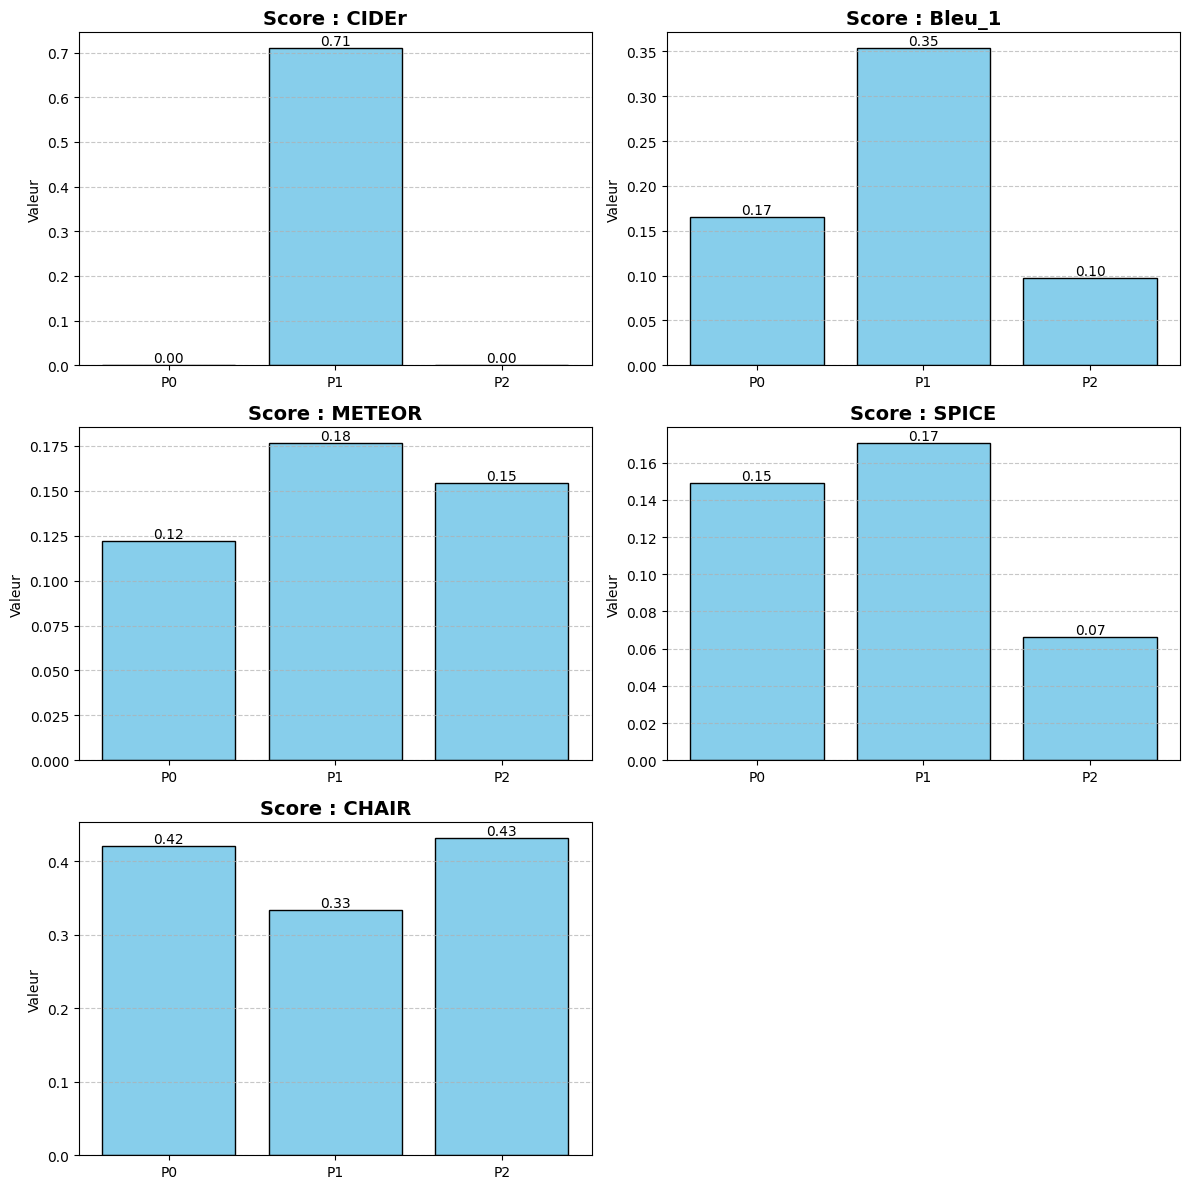

--------------------------------------------------
LÉGENDE DES PROMPTS :
P0 : Describe this image. Be concise.
P1 : Provide a very short, concise, and factual caption for this image. Maximum 10 words.
P2 : Décris cette image. Sois factuel et concis. Pas plus de dix mots.
--------------------------------------------------


In [10]:
plot_prompt_comparison(prompts_scores)

# Analyse des resultats : 

## Metriques utilisées : 

### Métriques de similarité : 

* CIDEr (Consensus-based Image Description Evaluation) : 
        Utilise une approche TF-IDF pour donner plus de poids aux mots importants et moins aux mots courants. 
        Elle mesure à quel point la légende générée capture le "consensus" des références humaines.
        Métrique standard dans les compétitions de captioning (comme COCO)

* BLEU (Bilingual Evaluation Understudy) :
        Compte le nombre de séquences de mots (n-grammes) qui apparaissent à la fois dans la légende générée et dans la référence. 
        Mesure de précision. Peu fiable car ne reconnaît pas les synonymes.

* METEOR : 
        Corrige la rigidité de BLEU. Prend en compte les correspondances exacts, mais aussi le stemming (racine des mots) et les synonymes.
        Additionellement il regarde l'order des mots pour évaluer sur le sens de la phrase : "Le chat mange la souris" vs "La souris mange le chat".
        Charge les synonymes via WordNet ce qu'il fait via Java.

* SPICE (Semantic Propositional Image Caption Evaluation) :
        transforme les captions (ground truth et response) en "graphes de scène" et compare ensuite ces graphes.


### Métrique d'hallucination

* CHAIR (Caption Hallucination Assessment with Image Relevance)
        : C'est une métrique spécialisée pour détecter les hallucinations. 
        Elle calcule le pourcentage d'objets mentionnés dans la légende qui ne sont pas présents dans l'image 
        (basé sur la liste d'objets connus par exemple grace une segmentation).

### Note : SPICE conssomme énormément de RAM, on a donc dû se limiter sur la simulation et notamment forcer le modèle à faire des descriptions courtes.

## Prompts :

* P0 : Describe this image. Be concise.
* P1 : Provide a very short, concise, and factual caption for this image. Maximum 10 words.
* P2 : Décris cette image. Sois factuel et concis. Pas plus de dix mots.

## Analyse :

### P0 vs P1

* CIDEr : Le prompt P1 atteint un score de 0.71, contre 0.00  pour P0. On explique cet écart par la nature du dataset COCO, dont le Ground Truth est constituée de légendes très brèves et factuelles : "A person standing at a table in a room". Le prompt P0 laisse le modèle générer des descriptions trop verbeuses qui s'éloignent des annotations de référence, même si on lui demande d'être concis.

* Score Bleu_1 et METEOR : Le prompt P1 obtient un score de 0.35 contre 0.17 pour P0, confirmant que contraindre le modèle à une sortie de moins de 10 mots maximise le décompte des séquences n-grams en commun. Nous pensons que l'écart entre entre P0 et P1 est plus faible avec METEOR (0.12/0.17) car cette métrique gére mieux les synonymes.

* Pour ce qui est des métriques de similarité, le fait de préciser d'être factuel et concis impacte clairement la performence.

### P2 : prompt français

* Sans surprise il y a peu de similarité exactes entre la description française du modèle et le ground truth anglais de COCO. D'où les faibles scores CIDER et BLEU. 

* A noter que le français et l'anglais ont beaucoup de mots en commun (au moins pour leur racines) donc METEOR semblerait capter cela, et SPICE détecte de légere similarités.

### Hallucinations : CHAIR 
La métrique CHAIR évalue le taux d'objets mentionnés par le modèle mais absents de l'image (un score plus bas est meilleur).

* P1 qui contraint le modèle à être le plus factuel possible obtient un meilleur score, il impose un cadre (0.33 vs 0.42 et 0.43).

* P0 et P2 se permettent d'être plus "bavard" et donc ont plus de chances d'halluciner.

## Conclusion : 
* Pour ces métriques et pour ce qui est de la précision des descriptions, le prompt qui impose un cadre et une limite de longueur est plus performent (comme attendu). 

* Evidemment un prompt en langue anglaise est préferable.